# TBParse Gallery with PyTorch

In [1]:
!pip install tensorflow
!pip install -U tbparse

In [2]:
import os
# Supress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from tbparse import SummaryReader
# Set random seed for reproducible results
np.random.seed(1234)
# Prepare temp dirs for storing event files
log_dir = "sample_run"

## Scalars

Ref: [add_scalars](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars)

In [3]:
writer = SummaryWriter(os.path.join(log_dir, "scalars"))
r = 5
for i in range(100):
    writer.add_scalars('run_14h', {'xsinx':i*np.sin(i/r),
                                    'xcosx':i*np.cos(i/r),
                                    'tanx': np.tan(i/r)}, i)
writer.close()
# This call adds three values to the same scalar plot with the tag
# 'run_14h' in TensorBoard's scalar section.

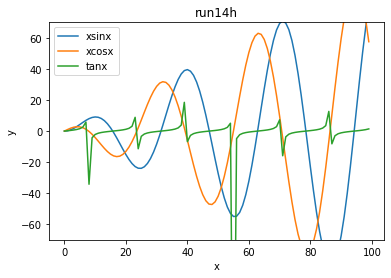

In [4]:
reader = SummaryReader(os.path.join(log_dir, "scalars"), extra_columns={'dir_name'})
df = reader.scalars
df_xsinx = df[df['dir_name'] == 'run_14h_xsinx']
df_xcosx = df[df['dir_name'] == 'run_14h_xcosx']
df_tanx = df[df['dir_name'] == 'run_14h_tanx']
fig = plt.figure()
plt.plot(df_xsinx['step'], df_xsinx['value'])
plt.plot(df_xcosx['step'], df_xcosx['value'])
plt.plot(df_tanx['step'], df_tanx['value'])
plt.ylim([-70, 70])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['xsinx', 'xcosx', 'tanx'])
plt.title('run14h')
plt.savefig("sample_run/scalars.png", facecolor='w')
plt.show()

## Tensors

Ref: [add_scalar](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalar)

In [5]:
writer = SummaryWriter(os.path.join(log_dir, "tensors"))
x = range(100)
for i in x:
    writer.add_scalar('y=2x', i * 2, i, new_style=True)
writer.close()

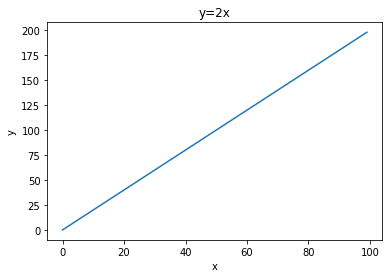

In [6]:
reader = SummaryReader(os.path.join(log_dir, "tensors"))
df = reader.tensors
fig = plt.figure()
plt.plot(df['step'], df['value'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('y=2x')
plt.savefig("sample_run/tensors.png", facecolor='w')
plt.show()

## Histograms

Ref: [add_histogram](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram)

In [7]:
writer = SummaryWriter(os.path.join(log_dir, "histograms"))
for i in range(10):
    x = np.random.random(1000)
    writer.add_histogram('distribution centers', x + i, i)
writer.close()

/home/johnson/tbparse/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


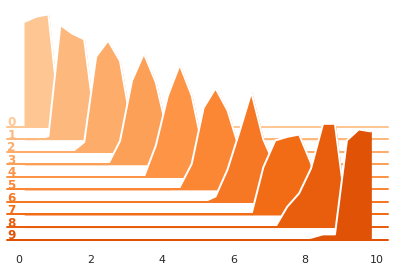

In [8]:
reader = SummaryReader(os.path.join(log_dir, "histograms"), pivot=True)
df = reader.histograms
# Set background
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Choose color palettes for the distributions
pal = sns.color_palette("Oranges", 20)[5:-5]
# Initialize the FacetGrid object (stacking multiple plots)
g = sns.FacetGrid(df, row='step', hue='step', aspect=15, height=.4, palette=pal)

def plot_subplots(x, color, label, data):
  ax = plt.gca()
  ax.text(0, .08, label, fontweight="bold", color=color,
          ha="left", va="center", transform=ax.transAxes)
  counts = data['distribution centers/counts'].iloc[0]
  limits = data['distribution centers/limits'].iloc[0]
  x, y = SummaryReader.histogram_to_bins(counts, limits, 0, 10)
  # Draw the densities in a few steps
  sns.lineplot(x=x, y=y, clip_on=False, color="w", lw=2)
  ax.fill_between(x, y, color=color)
# Plot each subplots with df[df['step']==i]
g.map_dataframe(plot_subplots, None)

# Add a bottom line for each subplot
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Set the subplots to overlap (i.e., height of each distribution)
g.figure.subplots_adjust(hspace=-.9)
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xlabel="", ylabel="")
g.despine(bottom=True, left=True)

# Reset to default matplotlib theme
mpl.rcParams.update(mpl.rcParamsDefault)
plt.savefig("sample_run/histograms.png", facecolor='w')

## Images

Ref: [add_image](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_image)

In [9]:
writer = SummaryWriter(os.path.join(log_dir, "images"))
img = np.zeros((3, 100, 100))
img[0] = np.arange(0, 10000).reshape(100, 100) / 10000
img[1] = 1 - np.arange(0, 10000).reshape(100, 100) / 10000
writer.add_image('my_image', img, 0)
writer.close()

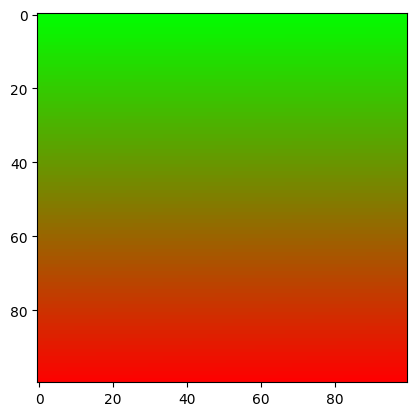

In [10]:
reader = SummaryReader(os.path.join(log_dir, "images"))
df = reader.images
image = df.loc[0, 'value']
plt.imshow(image)
plt.savefig("sample_run/images.png", facecolor='w')

## Audio

Ref: [add_audio](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_audio),
[waveio](https://github.com/WarrenWeckesser/wavio)

In [11]:
writer = SummaryWriter(os.path.join(log_dir, "audio"))
rate = 22050  # samples per second
T = 3         # sample duration (seconds)
f = 440.0     # sound frequency (Hz)
t = np.linspace(0, T, T*rate, endpoint=False)
x = np.sin(2*np.pi * f * t)
x = np.expand_dims(x, axis=0)
writer.add_audio('my_audio', x, 0, sample_rate=rate)
writer.close()

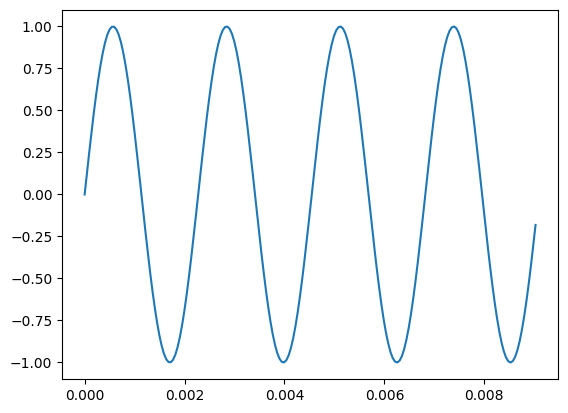

In [12]:
reader = SummaryReader(os.path.join(log_dir, "audio"), extra_columns={'sample_rate'})
df = reader.audio
x = df.loc[0, 'value']
rate = int(df.loc[0, 'sample_rate'])

T = len(x)//rate
t = np.linspace(0, T, T*rate, endpoint=False)
plt.plot(t[:200], x[:200])
plt.savefig("sample_run/audio.png", facecolor='w')

## HParams

Ref: [add_hparams](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams)

In [13]:
writer = SummaryWriter(os.path.join(log_dir, "hparams"))
for i in range(5):
    writer.add_hparams({'lr': 0.1*i, 'bsize': i},
                       {'hparam/accuracy': 10*i, 'hparam/loss': 10*i},
                       run_name=f'run{i}')
writer.close()

In [14]:
reader = SummaryReader(os.path.join(log_dir, "hparams"), pivot=True, extra_columns={'dir_name'})
df = reader.hparams
df

,bsize,lr,dir_name
0,0.0,0.0,run0
1,1.0,0.1,run1
2,2.0,0.2,run2
3,3.0,0.3,run3
4,4.0,0.4,run4


In [15]:
reader = SummaryReader(os.path.join(log_dir, "hparams"), pivot=True, extra_columns={'dir_name'})
df = reader.scalars
df

,step,hparam/accuracy,hparam/loss,dir_name
0,0,0.0,0.0,run0
1,0,10.0,10.0,run1
2,0,20.0,20.0,run2
3,0,30.0,30.0,run3
4,0,40.0,40.0,run4


## Text

Ref: [add_text](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_text)

In [16]:
writer = SummaryWriter(os.path.join(log_dir, "text"))
writer.add_text('lstm', 'This is an lstm', 0)
writer.add_text('rnn', 'This is an rnn', 10)
writer.close()

In [17]:
reader = SummaryReader(os.path.join(log_dir, "text"))
df = reader.text
df

,step,tag,value
0,0,lstm,This is an lstm
1,10,rnn,This is an rnn
